In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

Input DataFrame type: <class 'pandas.core.frame.DataFrame'>
Total instances in original dataset: 690
Instances held for extrapolation: 11
Instances used for training/validation: 679

Target Statistics (final_expandEvts):
Mean (censored=0): 53227800.02
Std Dev (censored=0): 174281183.67
Mean (all data): 750029157.52
Std Dev (all data): 635567837.57

Training Random Forest on censored=0 data...
Censored=0 Test Set RMSE: 65470045.2979
Censored=0 Test Set Normalized RMSE: 122.9997%
Censored=0 Test Set sMAPE: 21.55%
Censored=0 Test Set sMdAPE: 16.86%
Censored=0 CV Normalized RMSE: 136.2316%

Censored=0 Feature Importance (Top 10):
                   feature  importance
23  avg_pruneBacktrackEvts    0.277868
19                avg_evts    0.173093
21          avg_expandEvts    0.137147
24  max_pruneBacktrackEvts    0.087052
22          max_expandEvts    0.054417
20                max_evts    0.046002
15    pruneBacktrackEvts_3    0.031928
8             expandEvts_2    0.024733
14            e

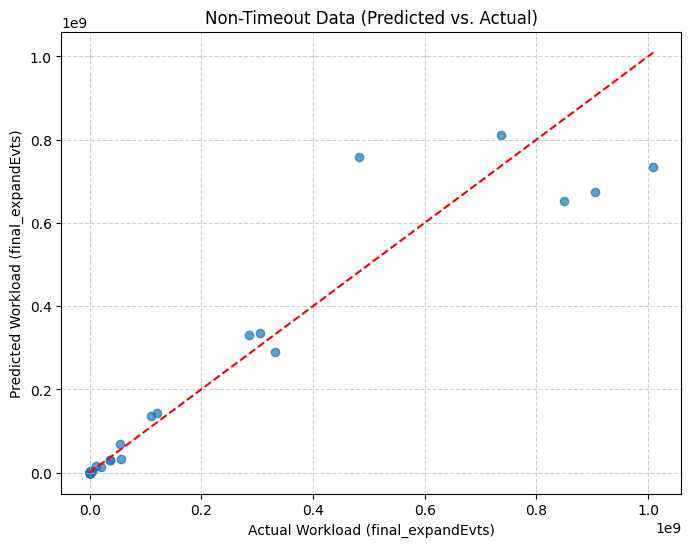

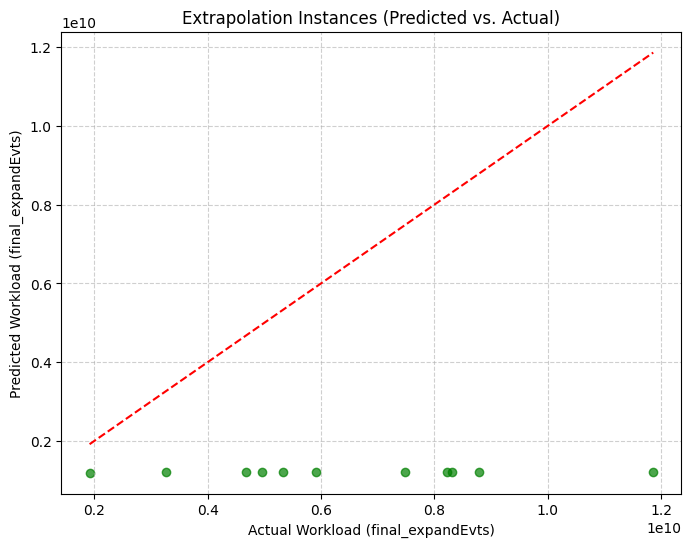

In [4]:
def train_random_forest_model(df, include_ratios=False, cv_folds=5, extrapolation_filenames=None):
    """
    Trains a Random Forest model on censored=0 data and validates on all data and a specific
    extrapolation set to assess generalizability. Uses relative error metrics.

    Parameters:
    - df (pandas.DataFrame): Preprocessed DataFrame with solver features.
    - include_ratios (bool): If True, includes ratio features; if False, excludes them (default: False).
    - cv_folds (int): Number of cross-validation folds (default: 5).
    - extrapolation_filenames (list): List of filenames for the extrapolation test set.

    Returns:
    - dict: Contains relative error metrics, CV scores, and feature importance for censored=0 test set,
            all data, and the new extrapolation set. It also returns the actual and predicted values
            for plotting.
    """
    try:
        # Validate input
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"Input 'df' must be a pandas DataFrame, got {type(df)}")
        print(f"Input DataFrame type: {type(df)}")
        
        # Define the extrapolation filenames if not provided
        if extrapolation_filenames is None:
            extrapolation_filenames = [
                'n27k3_v1.txt', 'n27k3_v2.txt', 'n27k3_v3.txt', 'n27k3_v4.txt',
                'n28k3_v1.txt', 'n28k3_v2.txt', 'n28k3_v3.txt', 'n28k3_v4.txt',
                'n28k3_v5.txt', 'n29k3_v1.txt', 'n29k3_v2.txt'
            ]
        
        # Separate extrapolation data
        df_extrapolation = df[df['filename'].isin(extrapolation_filenames)]
        df_model_data = df[~df['filename'].isin(extrapolation_filenames)]
        
        if df_extrapolation.empty:
            print("Warning: Extrapolation data not found in the DataFrame.")
            
        print(f"Total instances in original dataset: {len(df)}")
        print(f"Instances held for extrapolation: {len(df_extrapolation)}")
        print(f"Instances used for training/validation: {len(df_model_data)}")

        # Feature selection
        exclude_cols = ['filename', 'final_expandEvts', 'stop_iter', 'final_maxStackDepth']
        if not include_ratios:
            exclude_cols.extend([f'expandEvts_ratio_{i}' for i in range(1, 6)])
            exclude_cols.extend([f'pruneBacktrackEvts_ratio_{i}' for i in range(1, 6)])
        features = [col for col in df.columns if col not in exclude_cols and col != 'censored']
        
        # Print target statistics (on the model data, excluding extrapolation)
        print("\nTarget Statistics (final_expandEvts):")
        mean_censored = df_model_data[df_model_data['censored'] == 0]['final_expandEvts'].mean()
        std_censored = df_model_data[df_model_data['censored'] == 0]['final_expandEvts'].std()
        mean_all = df_model_data['final_expandEvts'].mean()
        std_all = df_model_data['final_expandEvts'].std()
        print(f"Mean (censored=0): {mean_censored:.2f}")
        print(f"Std Dev (censored=0): {std_censored:.2f}")
        print(f"Mean (all data): {mean_all:.2f}")
        print(f"Std Dev (all data): {std_all:.2f}")
        
        # Define relative error metrics
        def calculate_smape(y_true, y_pred):
            y_true, y_pred = np.array(y_true), np.array(y_pred)
            denominator = np.abs(y_true) + np.abs(y_pred)
            mask = denominator != 0
            if mask.sum() == 0:
                return np.nan
            smape = np.mean(2 * np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]) * 100
            return smape
        
        def calculate_smdape(y_true, y_pred):
            y_true, y_pred = np.array(y_true), np.array(y_pred)
            denominator = np.abs(y_true) + np.abs(y_pred)
            mask = denominator != 0
            if mask.sum() == 0:
                return np.nan
            smape_terms = 2 * np.abs(y_true[mask] - y_pred[mask]) / denominator[mask] * 100
            return np.median(smape_terms)
        
        def calculate_normalized_rmse(y_true, y_pred, mean_y):
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            return rmse / mean_y if mean_y != 0 else np.nan
        
        # Train on non-timeout (censored=0) data (from the model data set)
        print("\nTraining Random Forest on censored=0 data...")
        df_censored = df_model_data[df_model_data['censored'] == 0]
        if df_censored.empty:
            print("Warning: No censored=0 instances found for training. Exiting.")
            return None
        
        X_censored = df_censored[features]
        y_censored = df_censored['final_expandEvts']
        X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_censored, y_censored, test_size=0.2, random_state=42)
        
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train_c, y_train_c)
        
        # Evaluate on censored=0 test set
        y_pred_c = rf_model.predict(X_test_c)
        rmse_censored = np.sqrt(mean_squared_error(y_test_c, y_pred_c))
        norm_rmse_censored = calculate_normalized_rmse(y_test_c, y_pred_c, mean_censored)
        smape_censored = calculate_smape(y_test_c, y_pred_c)
        smdape_censored = calculate_smdape(y_test_c, y_pred_c)
        cv_scores = cross_val_score(rf_model, X_censored, y_censored, cv=cv_folds, scoring='neg_root_mean_squared_error')
        cv_norm_rmse_censored = (-cv_scores.mean()) / mean_censored if mean_censored != 0 else np.nan
        print(f"Censored=0 Test Set RMSE: {rmse_censored:.4f}")
        print(f"Censored=0 Test Set Normalized RMSE: {norm_rmse_censored:.4%}")
        print(f"Censored=0 Test Set sMAPE: {smape_censored:.2f}%")
        print(f"Censored=0 Test Set sMdAPE: {smdape_censored:.2f}%")
        print(f"Censored=0 CV Normalized RMSE: {cv_norm_rmse_censored:.4%}")
        
        importance_censored = pd.DataFrame({
            'feature': X_censored.columns,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        print("\nCensored=0 Feature Importance (Top 10):")
        print(importance_censored.head(10))
        
        # Validate on all data (from the model data set)
        print("\nValidating on all data (excluding extrapolation set)...")
        X_all = df_model_data[features]
        y_all = df_model_data['final_expandEvts']
        y_pred_all = rf_model.predict(X_all)
        rmse_all = np.sqrt(mean_squared_error(y_all, y_pred_all))
        norm_rmse_all = calculate_normalized_rmse(y_all, y_pred_all, mean_all)
        smape_all = calculate_smape(y_all, y_pred_all)
        smdape_all = calculate_smdape(y_all, y_pred_all)
        print(f"All Model Data RMSE: {rmse_all:.4f}")
        print(f"All Model Data Normalized RMSE: {norm_rmse_all:.4%}")
        print(f"All Model Data sMAPE: {smape_all:.2f}%")
        print(f"All Model Data sMdAPE: {smdape_all:.2f}%")
        
        # Cross-validation for all model data
        print("\nPerforming cross-validation on all model data...")
        cv_scores_all = cross_val_score(rf_model, X_all, y_all, cv=cv_folds, scoring='neg_root_mean_squared_error')
        cv_norm_rmse_all = (-cv_scores_all.mean()) / mean_all if mean_all != 0 else np.nan
        print(f"All Model Data CV Normalized RMSE: {cv_norm_rmse_all:.4%}")

        # Evaluate on the held-out extrapolation data
        print("\nEvaluating on held-out extrapolation data...")
        X_extrapolation = df_extrapolation[features]
        y_extrapolation = df_extrapolation['final_expandEvts']
        y_pred_extrapolation = rf_model.predict(X_extrapolation)

        mean_extrapolation = y_extrapolation.mean()
        rmse_extrapolation = np.sqrt(mean_squared_error(y_extrapolation, y_pred_extrapolation))
        norm_rmse_extrapolation = calculate_normalized_rmse(y_extrapolation, y_pred_extrapolation, mean_extrapolation)
        smape_extrapolation = calculate_smape(y_extrapolation, y_pred_extrapolation)
        smdape_extrapolation = calculate_smdape(y_extrapolation, y_pred_extrapolation)
        
        print(f"Extrapolation Set RMSE: {rmse_extrapolation:.4f}")
        print(f"Extrapolation Set Normalized RMSE: {norm_rmse_extrapolation:.4%}")
        print(f"Extrapolation Set sMAPE: {smape_extrapolation:.2f}%")
        print(f"Extrapolation Set sMdAPE: {smdape_extrapolation:.2f}%")

        return {
            'rmse_censored_test': rmse_censored,
            'norm_rmse_censored_test': norm_rmse_censored,
            'smape_censored_test': smape_censored,
            'smdape_censored_test': smdape_censored,
            'cv_norm_rmse_censored': cv_norm_rmse_censored,
            'rmse_all': rmse_all,
            'norm_rmse_all': norm_rmse_all,
            'smape_all': smape_all,
            'smdape_all': smdape_all,
            'cv_norm_rmse_all': cv_norm_rmse_all,
            'feature_importance': importance_censored,
            'rmse_extrapolation': rmse_extrapolation,
            'norm_rmse_extrapolation': norm_rmse_extrapolation,
            'smape_extrapolation': smape_extrapolation,
            'smdape_extrapolation': smdape_extrapolation,
            'y_test_c': y_test_c,
            'y_pred_c': y_pred_c,
            'y_extrapolation': y_extrapolation,
            'y_pred_extrapolation': y_pred_extrapolation
        }
    
    except Exception as e:
        print(f"Error in train_random_forest_model: {e}")
        return None


def plot_non_timeout_data(y_test, y_pred):
    """
    Creates a scatter plot to visualize predicted vs. actual values for non-timeout test data.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title('Non-Timeout Data (Predicted vs. Actual)')
    plt.xlabel('Actual Workload (final_expandEvts)')
    plt.ylabel('Predicted Workload (final_expandEvts)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_extrapolation_data(y_extrapolation, y_pred_extrapolation):
    """
    Creates a scatter plot to visualize predicted vs. actual values for held-out extrapolation instances.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_extrapolation, y_pred_extrapolation, color='green', alpha=0.7)
    plt.plot([y_extrapolation.min(), y_extrapolation.max()], [y_extrapolation.min(), y_extrapolation.max()], 'r--')
    plt.title('Extrapolation Instances (Predicted vs. Actual)')
    plt.xlabel('Actual Workload (final_expandEvts)')
    plt.ylabel('Predicted Workload (final_expandEvts)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


# --- Main execution block ---
try:
    df = pd.read_excel("structured_data.xlsx")
except FileNotFoundError:
    print("Error: structured_data.xlsx not found. Please provide the data file.")
    df = pd.DataFrame()

if not df.empty:
    results = train_random_forest_model(df, include_ratios=True)
    if results and 'y_test_c' in results:
        # Call the new plotting functions separately
        plot_non_timeout_data(results['y_test_c'], results['y_pred_c'])
        plot_extrapolation_data(results['y_extrapolation'], results['y_pred_extrapolation'])
